In [35]:
%matplotlib inline
import sys, scipy, os, warnings, librosa, argparse, pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction import image
from librosa.util import normalize
import scipy.io.wavfile as wav

sys.path.append('../src')
import laplacian, gradient, plotGraph, librosaF, qUpdate
import RecurrenceMatrix as RM

# Load signal, true boundary, original Q, learned Q

1. signal has been cqt, beat syc
2. true boundary imported and processed from SALAMI, been time2frame conversion, been beat2beat conversion
3. Q is learned by minimizing || L_true - L ||_2
4. the each differential term and chain rule is confirmed numerically and analytically. 

In [49]:
Q_init = np.random.rand(84) + 1e-7 #84 is cqt number of bins
Q = np.load("./Q/OnlyOne_Alpha5_0/OnlyOne_Alpha5_0/OnlyOne_Alpha5_0_step137.npy")
cqt = np.load('./tempArray/cqt.npy')
beats = np.load('./tempArray/beats.npy')

In [50]:
cqt_med, frameConversion = librosaF.sync(cqt, beats, aggregate=np.median)
cqt_med = cqt_med.T
cqt_med = normalize(cqt_med, norm=2)
sr = 44100
print "Perform loadInterval2Frame ..."
interval = librosaF.loadInterval2Frame("./tempArray/anno/698/parsed/textfile1_uppercase.txt", sr, frameConversion)

print "Creating Q vector ..."
Q_init = np.random.rand(cqt_med.shape[1]) + 1e-7

gm0 = RM.featureQ2GaussianMatrix(cqt_med, Q_init) #(nSample, nFeature)
gm = RM.featureQ2GaussianMatrix(cqt_med, Q) #(nSample, nFeature)
L = scipy.sparse.csgraph.laplacian(gm, normed=True)
m_true = RM.label2RecurrenceMatrix("../data/2.jams", gm.shape[0], interval)
L_true = scipy.sparse.csgraph.laplacian(m_true, normed=True)

Perform loadInterval2Frame ...
buffer range
[[array([], dtype=float64), 'Silence'], [array([ 0, 18]), 'I'], [array([18, 50]), 'V'], [array([50, 81]), 'V'], [array([ 81, 113]), 'C'], [array([113, 130]), 'T'], [array([130, 161]), 'V'], [array([161, 193]), 'C'], [array([193, 242]), "T'"], [array([242, 274]), 'C'], [array([274, 321]), 'O'], [array([], dtype=float64), 'Silence']]
[[array([ 0, 18]), 'I'], [array([18, 50]), 'V'], [array([50, 81]), 'V'], [array([ 81, 113]), 'C'], [array([113, 130]), 'T'], [array([130, 161]), 'V'], [array([161, 193]), 'C'], [array([193, 242]), "T'"], [array([242, 274]), 'C'], [array([274, 321]), 'O']]
Creating Q vector ...


# Recurrent matrix before and after learned Q

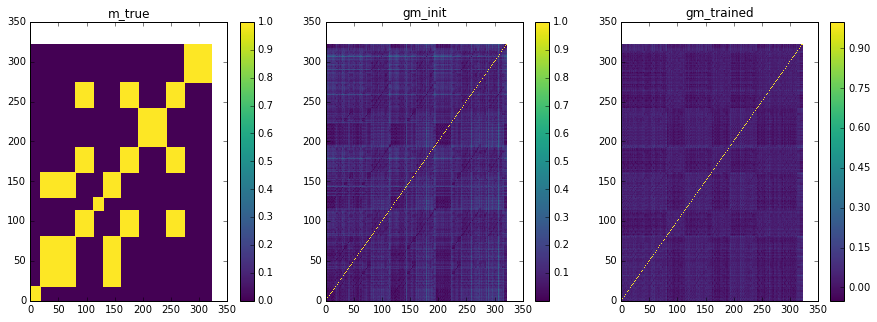

In [51]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.pcolor(m_true, cmap="viridis")
plt.colorbar()
plt.title("m_true")

plt.subplot(1, 3, 2)
plt.pcolor(gm0, cmap="viridis")
plt.colorbar()
plt.title("gm_init")

plt.subplot(1, 3, 3)
plt.pcolor(gm, cmap="viridis")
plt.colorbar()
plt.title("gm_trained")

plt.show()

# Boundary Detection
- Eigenvectors after for the top3 can show the clean feature
- Here we do the test for top10 and top3 eigenvectors

In [81]:
#Get Laplacian matrix and get top10 eigen vectors
Y10_true = laplacian.getNormLaplacian(m_true, 10)
Y10 = laplacian.getNormLaplacian(gm, 10)
Y3_true = laplacian.getNormLaplacian(m_true, 3)
Y3 = laplacian.getNormLaplacian(gm, 3)

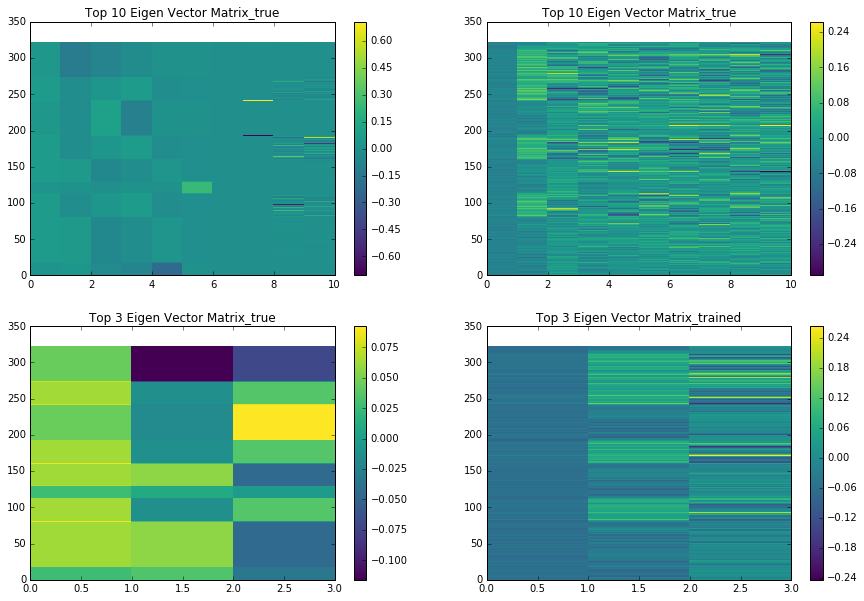

In [82]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.pcolor(Y10_true, cmap="viridis")
plt.colorbar()
plt.title("Top 10 Eigen Vector Matrix_true")

plt.subplot(2, 2, 2)
plt.pcolor(Y10, cmap="viridis")
plt.colorbar()
plt.title("Top 10 Eigen Vector Matrix_true")

plt.subplot(2, 2, 3)
plt.pcolor(Y3_true, cmap="viridis")
plt.colorbar()
plt.title("Top 3 Eigen Vector Matrix_true")

plt.subplot(2, 2, 4)
plt.pcolor(Y3, cmap="viridis")
plt.colorbar()
plt.title("Top 3 Eigen Vector Matrix_trained")

plt.show()

In [83]:
def boundaryDetection(Y, nCluster):
    row_leng = np.linalg.norm(Y, axis=1) #get length of each row
    row_leng[row_leng==0] = 1 #replace the legth of 0 to 1
    Y_norm = Y / row_leng[:, np.newaxis]

    clf = KMeans(n_clusters=nCluster, max_iter=1000).fit(Y_norm)
    centroids, labels = clf.cluster_centers_, clf.labels_

    boundary = []
    for idx in xrange(len(labels)-1):
        if labels[idx] != labels[idx+1]:
            boundary += [idx]
    
    return boundary, centroids

nCluster = 2
b10_true, c10_true = boundaryDetection(Y10_true, nCluster)
b10, c10 = boundaryDetection(Y10, nCluster)
b3_true, c3_true = boundaryDetection(Y3_true, nCluster)
b3, c3 = boundaryDetection(Y3, nCluster)

- The Q matrix after training gives the top3 eigen vector able to detect rough boundaries

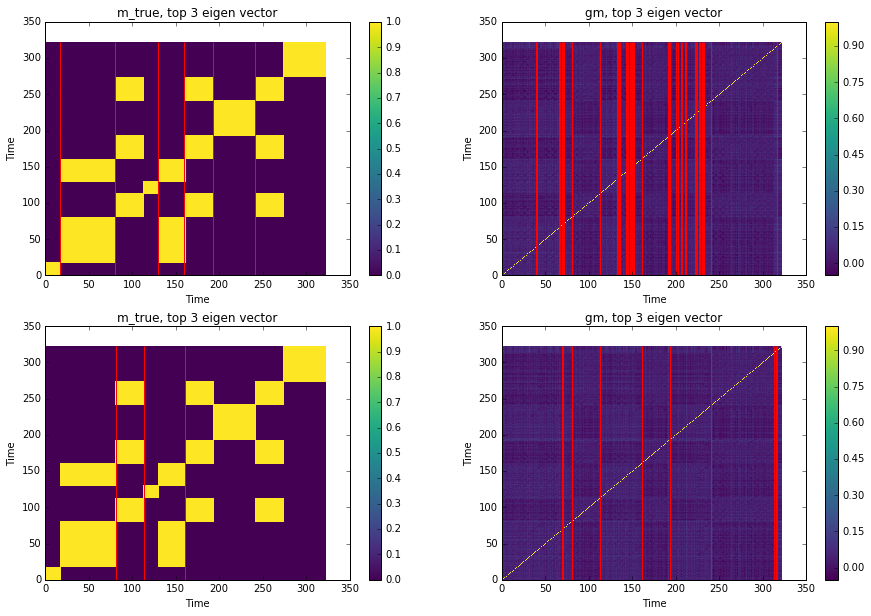

In [84]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.pcolor(m_true, cmap="viridis")
plt.colorbar()
plt.vlines(b10_true, 0, m_true.shape[0], color='r')
plt.title('m_true, top 3 eigen vector')
plt.xlabel('Time')
plt.ylabel('Time')

plt.subplot(2, 2, 2)
plt.pcolor(gm, cmap="viridis")
plt.colorbar()
plt.vlines(b10, 0, m_true.shape[0], color='r')
plt.title('gm, top 3 eigen vector')
plt.xlabel('Time')
plt.ylabel('Time')

plt.subplot(2, 2, 3)
plt.pcolor(m_true, cmap="viridis")
plt.colorbar()
plt.vlines(b3_true, 0, m_true.shape[0], color='r')
plt.title('m_true, top 3 eigen vector')
plt.xlabel('Time')
plt.ylabel('Time')

plt.subplot(2, 2, 4)
plt.pcolor(gm, cmap="viridis")
plt.colorbar()
plt.vlines(b3, 0, m_true.shape[0], color='r')
plt.title('gm, top 3 eigen vector')
plt.xlabel('Time')
plt.ylabel('Time')

plt.show()